In [1]:
# pip install -r requirements.txt

In [2]:
import os
import pandas as pd
import numpy as np
from dwave.system import LeapHybridCQMSampler, LeapHybridSampler
from dimod import ConstrainedQuadraticModel,  QuadraticModel, quicksum, Integer
from dotenv import load_dotenv, find_dotenv
import networkx as nx
import re
import random
import matplotlib
try:
    import matplotlib.pyplot as plt
except ImportError:
    matplotlib.use("agg")
    import matplotlib.pyplot as plt

In [3]:
# Load Environmental Variables
load_dotenv(find_dotenv())
token = os.environ['DWAVE_API_KEY'] 

In [4]:
# Import the data
import csv

with open('locations.csv', 'r') as f:
    reader = csv.DictReader(f)
    locations = {}
    for row in reader:
        name = row['Location']
        x_coord = float(row['X-Coord'])
        y_coord = float(row['Y-Coord'])
        assigned = int(row['Assigned'])
        demand = int(row['Projected Demand'])
        locations[name] = {'x_coord': x_coord, 'y_coord': y_coord, 'assigned': assigned, 'demand': demand}



In [5]:
# Reshape the initial data format in more useful structure
def summarize_data(original_dict):
    new_dict = {}
    for i, location in enumerate(original_dict.values()):
        new_dict[i] = (location['x_coord'], location['y_coord'])
    demand = {i: location['demand'] for i, location in enumerate(original_dict.values())}
    assigned = {i: location['assigned'] for i, location in enumerate(original_dict.values())}
    return new_dict, demand, assigned

In [6]:
def build_cqm(locations):

    # Compute distance matrix using Haversine distance
    def haversine(coord1, coord2):
        R = 6371  # Earth radius in km
        lat1, lon1 = coord1
        lat2, lon2 = coord2
        dlat = np.deg2rad(lat2 - lat1)
        dlon = np.deg2rad(lon2 - lon1)
        a = np.sin(dlat / 2) ** 2 + np.cos(np.deg2rad(lat1)) * np.cos(np.deg2rad(lat2)) * np.sin(dlon / 2) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        return R * c
    
    # Provide the cost per km
    c = 100

    # Define the number of locations 
    num_locations = len(locations)

    dist = {(i, j): haversine(L[i], L[j]) for i in L for j in L}

    # Define integer variable for number of helicopters to be moved from location i to j, ∀i∈L, ∀j∈L
    z = {
    (i, j): Integer('z{}_{}'.format(i, j), lower_bound=0,
                    upper_bound=100)
    for i in range(num_locations) for j in range(num_locations) if i !=j
       }

    #Instantiate the Constrained Quadratic Model
    cqm = ConstrainedQuadraticModel()
    
    # Define the objective function
    objective = sum(dist[i, j] * c * z[(i,j)] for i in L for j in L if i != j)
    cqm.set_objective(objective)


    # Define the constraint
    for i in L:
        demand = di[i] - si[i]
        flow_balance = sum(z[(j,i)] for j in L if j != i) - sum(z[(i,j)] for j in L if j != i)
        cqm.add_constraint(flow_balance == demand)

    return (cqm)

In [7]:
def sample (cqm):
    
    # Solve the problem
    sampler = LeapHybridCQMSampler(token=token)
    print("Submitting CQM to solver {}.".format(sampler.solver.name))
    
    # Sample from the model
    sampleset = sampler.sample_cqm(cqm, label='Air Ambulance Reassignment Problem')
    feasible_sampleset = sampleset.filter(lambda row: row.is_feasible)
    if not len(feasible_sampleset):
        raise ValueError("No feasible solution found")

    # Get the lowest feasible energy solution and store the solution variable
    best = feasible_sampleset.first
    result = [(key, val) for key, val in best.sample.items() if val==1.0]
    return result

In [8]:
def parse_data(data):
    pattern = r"(\d+)"
    new_data = {}
    for item in data:
        location = re.findall(pattern, item[0])
        key_list = list(locations.keys())
        key_index1 = int(location[0]) 
        key_index2 = int(location[1]) 
        key_name1 = key_list[key_index1]
        key_name2 = key_list[key_index2]
        name = key_name1 + "-> " + key_name2
        value = int(item[1])
        new_data[name] = value
    return new_data


In [9]:
def restructure_locations_dict(locations_dict):
    coords_dict = {}
    for city, data in locations_dict.items():
        x_coord = int(data['x_coord'])
        y_coord = int(data['y_coord'])
        coords_dict[city] = (x_coord, y_coord)
    return coords_dict


In [10]:
def draw_graph_with_arrows(coords_dict, routes_data):
    
    # create graph
    G = nx.DiGraph()

    # add nodes with coordinates as attributes
    for city, coords in coords_dict.items():
        G.add_node(city, pos=coords)

    # add edges with weights as attributes
    for route, weight in routes_data.items():
        start, end = route.split('->')
        G.add_edge(start.strip(), end.strip(), weight=weight)

    # get node positions from node attributes
    pos = nx.get_node_attributes(G, 'pos')

    # get edge weights from edge attributes
    edge_weights = nx.get_edge_attributes(G, 'weight')

    # draw graph with arrows and labels
    nx.draw_networkx(G, pos, arrows=True, with_labels=True, edge_color='r', width=4)

    # draw edge weights
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights)

    # Save the graph as a png file
    plt.savefig("graph.png", dpi=300, bbox_inches='tight')

    # show plot
    plt.show()

In [11]:
L, di, si = summarize_data(locations)

In [12]:
cqm = build_cqm(locations)
sample = sample(cqm)

Submitting CQM to solver hybrid_constrained_quadratic_model_version1.


In [13]:
result = parse_data(sample)
result

{'OKA-> Chicago': 1,
 'Kansas City-> Indianapolis': 1,
 'Kansas City-> Minneapolis': 1}

In [14]:
coords_dict = restructure_locations_dict(locations)

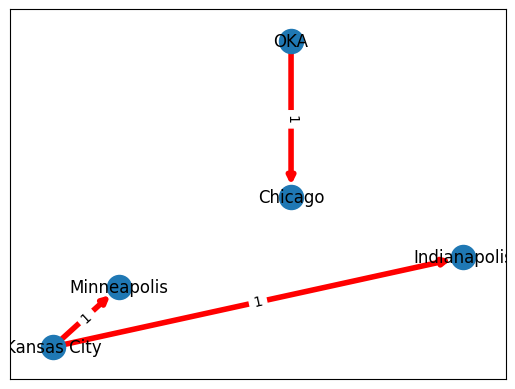

In [15]:
draw_graph_with_arrows(coords_dict, result)